In [20]:
from utils.Auger.SD.Monitoring import Monit
from utils.binaries import *
from utils import CONSTANTS

monit = Monit('/cr/data01/filip/Data/daqIntegrationTests/v14/mc_2024_09_16_07h20.root')
t, (wcd1, wcd2, wcd3) = monit('fTime', 136), monit('fPeak', 136).T
mask = [True if v != 0 else False for v in wcd3]

_, t_gps, pmt, *histos = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v14/out.txt', unpack=True)
histo_mask = np.where(np.sum(np.array(histos).T[:, :5], axis=1))[0]

t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v14/calib.test', unpack=True)

nan_mask = np.isnan(t_muonbuffer)
muonfill = lambda x: x[~nan_mask]
t_muonbuffer = muonfill(t_muonbuffer)
ssd = muonfill(ssd) / (2.64 * 10)
mf_wcd1 = muonfill(mf_wcd1)/10
mf_wcd2 = muonfill(mf_wcd2)/10
mf_wcd3 = muonfill(mf_wcd3)/10
t_muonbuffer += 1726224000

15:51:15 (  +14.2s) [INFO   ] -- received 1 file(s) as input
15:51:15 (  +153ms) [INFO   ] -- View monit keys with self.keys()
15:51:15 (    +5ms) [INFO   ] -- found 225 entries for key fTime and station #136
15:51:15 (    +8ms) [INFO   ] -- found 225 entries for key fPeak and station #136


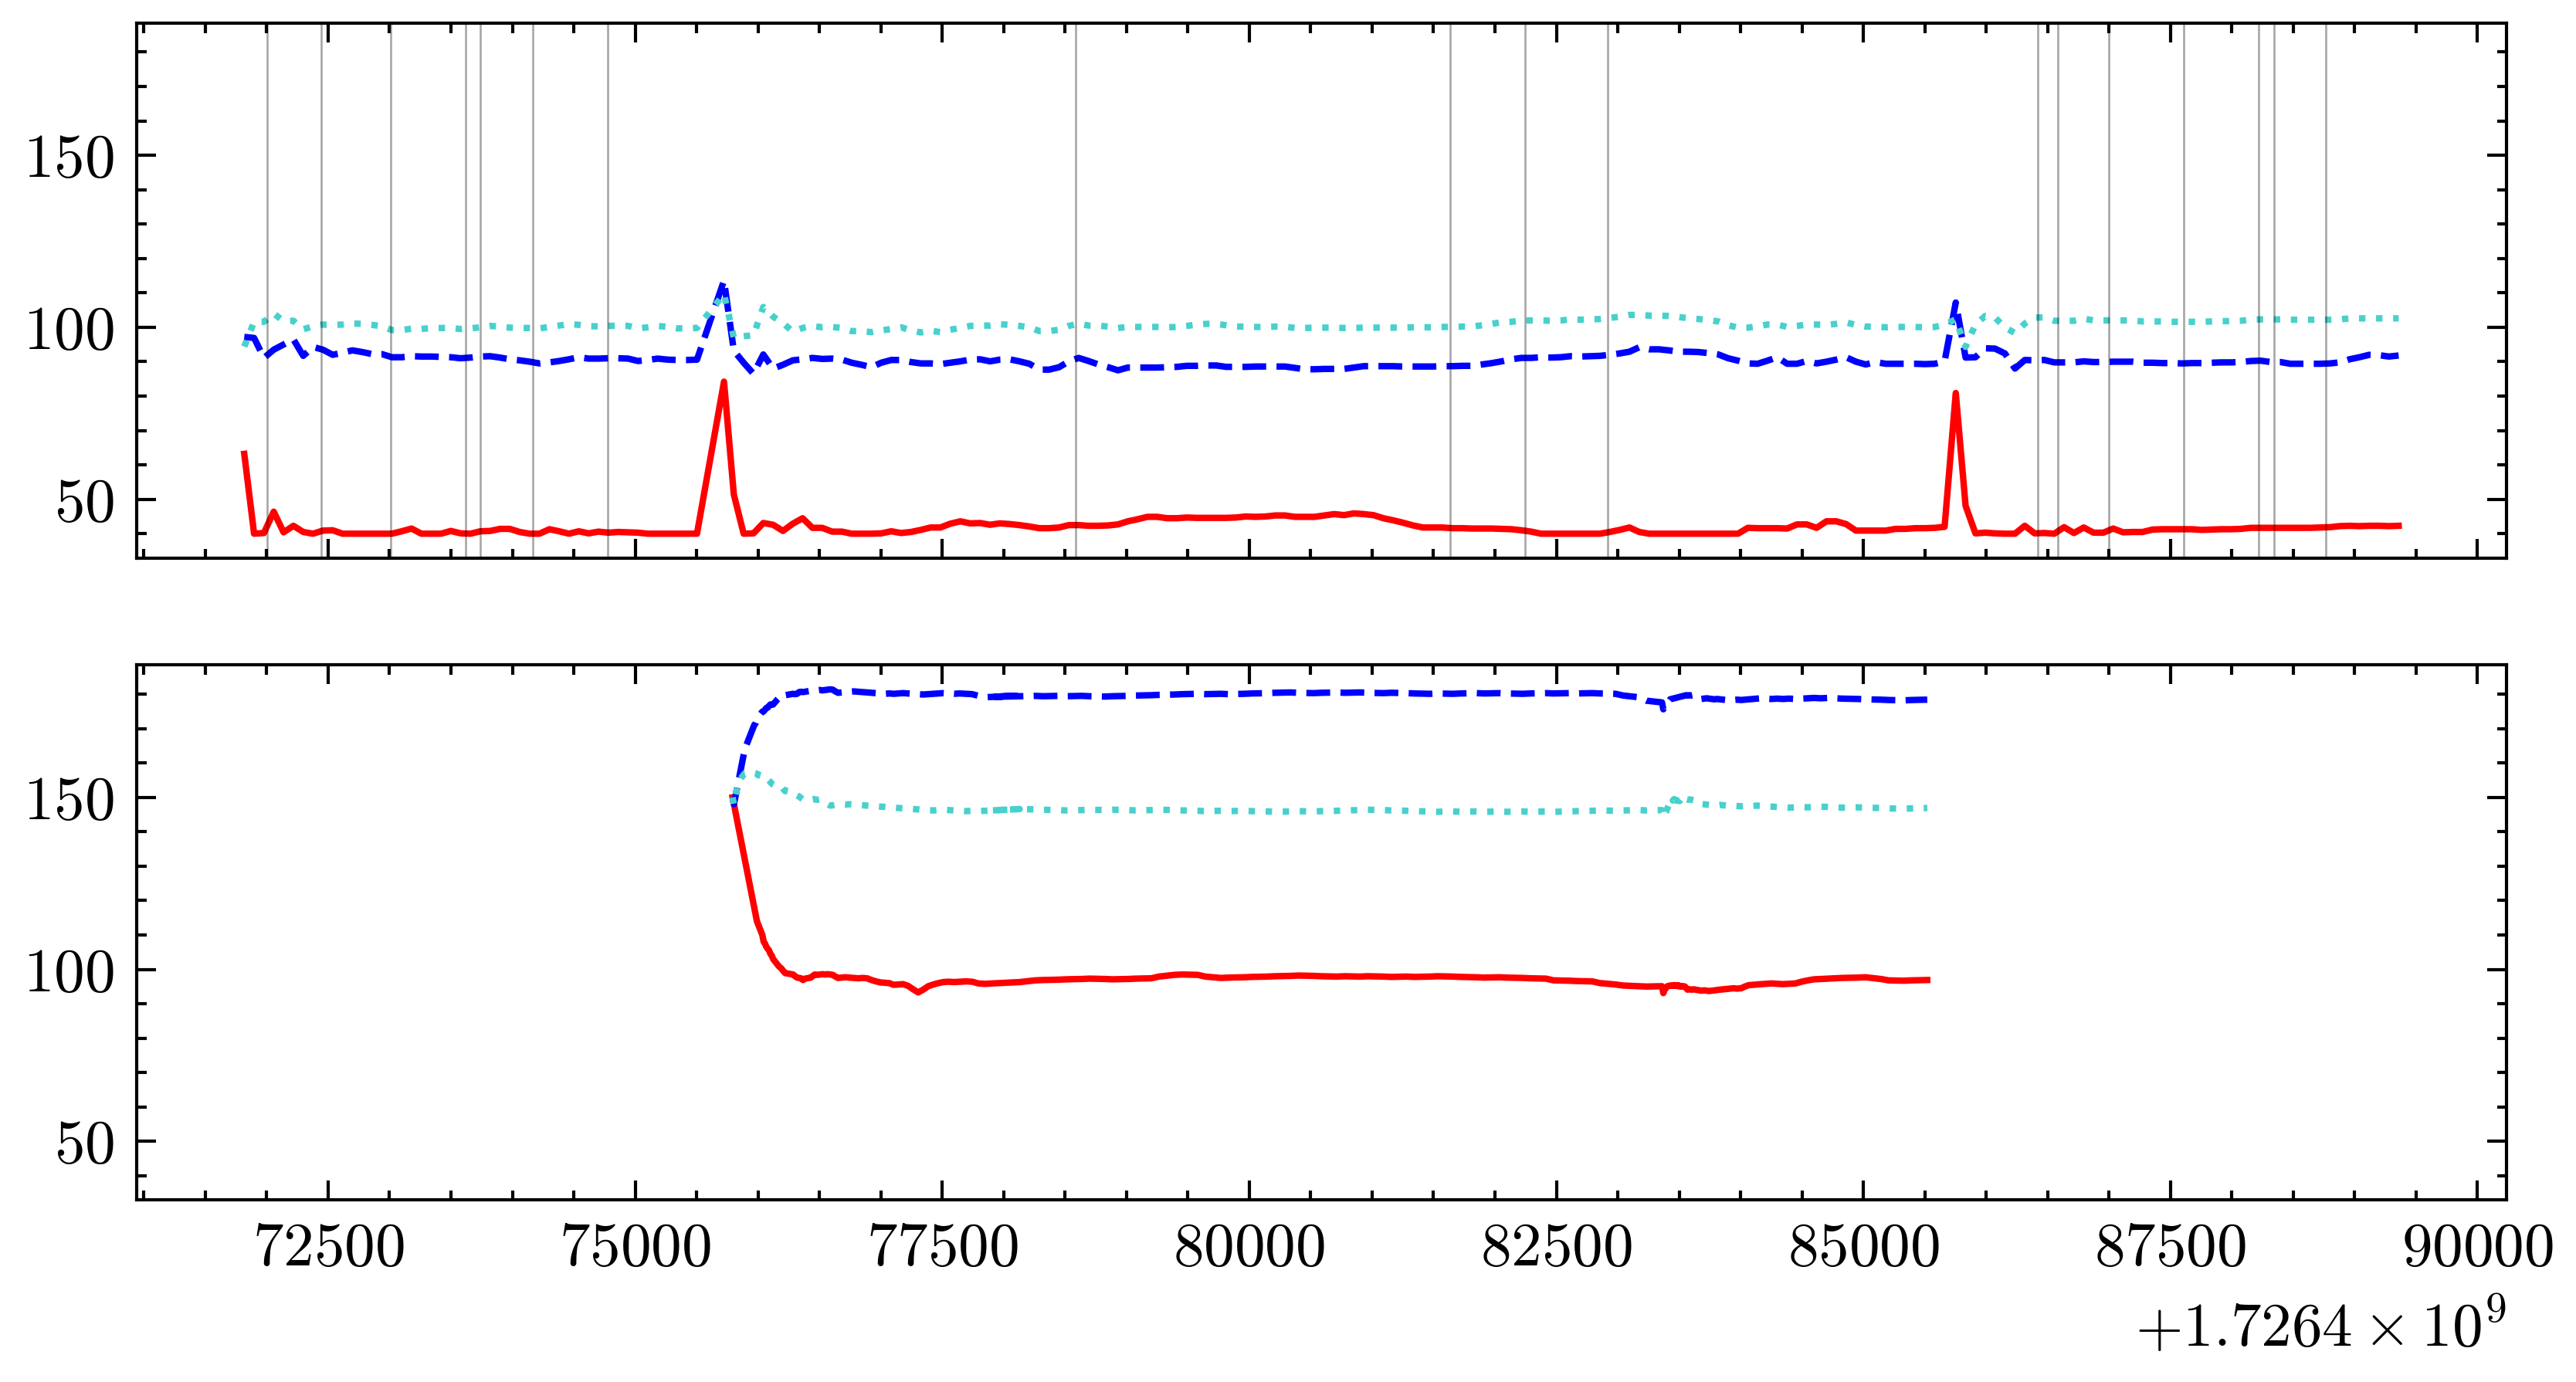

In [24]:
from utils.plotting import *

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

ax1.plot(t[mask], wcd1[mask], c='r', label='WCD1')
ax1.plot(t[mask], wcd2[mask], c='b', label='WCD2')
ax1.plot(t[mask], wcd3[mask], c='mediumturquoise', label='WCD3')

ax2.plot(t_muonbuffer, mf_wcd1, c='r')
ax2.plot(t_muonbuffer, mf_wcd2, c='blue')
ax2.plot(t_muonbuffer, mf_wcd3, c='mediumturquoise')

for tx, p, histo in zip(t_gps[histo_mask], pmt[histo_mask], np.array(histos)[histo_mask]):
    ax1.axvline(tx + CONSTANTS.GPS_OFFSET, alpha=0.1, lw=0.3)

    

# for tx in t_gps[~histo_mask]:
#     plt.axvline(tx + CONSTANTS.GPS_OFFSET, alpha=0.05, lw=0.6,c='r')

In [ ]:

def parabola(x, a, b, c):
    return a * x**2 + b*x + c

def make_histo(counts, skip_to_threshold = 12):
     
    # see Station.h in Framework/SDetector
    ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])
    ADC_width = np.diff(ADC_bin_edges)    
    histo = []

    for i, count in enumerate(counts[skip_to_threshold:]):
        idx = i + skip_to_threshold
        width = ADC_width[idx]
        wiggle = np.random.uniform(-0.5*width, 0.5*width, int(count))
        array = np.array([ADC[idx] for _ in range(int(count))])
        histo += [w + a for w, a in zip(wiggle, array)]

    return histo

def make_histo_fit(histogram, _id, time):
    binned, edges = np.histogram(histogram, bins=1000)
    position_of_peak = np.argmax(binned)
    start, stop = max(0, position_of_peak - 20), position_of_peak + 50
    x_fit = 0.5 * (edges[1:] + edges[:-1])

    try:
        (a, b, _), pp = curve_fit(parabola, x_fit[start:stop], np.log(binned)[start:stop], 
                            bounds=[[-np.inf, 0, 0],[0, np.inf, np.inf]],
                            p0=[-1000, 1, 1e3],
                            check_finite=True)
    
    except ValueError:
        a, b, _ = np.nan, np.nan, np.nan

    # if -b/(2*a) is np.nan:
    #     plt.figure()
    #     plt.plot(x_fit, np.exp(parabola(x_fit, a, b, _)), label='lstsq. fit')
    #     plt.plot(x_fit, binned, label='SSD histo')
    #     plt.axvline(x_fit[start], ls='--')
    #     plt.axvline(x_fit[stop], ls='--')
    #     plt.yscale('log')
    #     plt.legend()
    #     plt.savefig(f'/cr/users/filip/plots/failed_{_id}_{time}.png')

    return -b/(2*a) if 10 < -b/(2*a) < 250 else np.nan

